In [1]:
#!pip install wrapt

In [2]:
from textblob import TextBlob
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers


from warnings import filterwarnings
filterwarnings('ignore')

Using TensorFlow backend.


## 1-) Data Preprocessing 1

In [3]:
import pandas as pd 
data = pd.read_csv("train.tsv",sep = "\t")

In [4]:
data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


* The numbers in the sentiment  column go from 0 to 4.


* These number  scaled the comments  from most negative to  most positive.


* Here we will recreate the sentiment column so that the numbers 0 and 1 represent a negative comment.
 
 
* Here we will recreate the sentiment column so that the numbers 3 and 4 represent a positive comment.

In [5]:
data["Sentiment"].replace(0, "negative", inplace = True)
data["Sentiment"].replace(1, "negative", inplace = True)

In [6]:
data["Sentiment"].replace(3,  "pozitive", inplace = True)
data["Sentiment"].replace(4,  "pozitive", inplace = True)

In [7]:
data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,negative
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


* We will removed the middle-valued comments, which are represented by values of 2 under the sentiment column, from the dataset.

In [11]:
data = data[(data["Sentiment"] == "negative") | (data["Sentiment"] == "pozitive")]

In [12]:
data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,negative
21,22,1,good for the goose,pozitive
22,23,1,good,pozitive
33,34,1,"the gander , some of which occasionally amuses...",negative
46,47,1,amuses,pozitive


In [13]:
data.groupby("Sentiment").count()

,PhraseId,SentenceId,Phrase
Sentiment,,,
negative,34345,34345,34345
pozitive,42133,42133,42133


In [14]:
df = pd.DataFrame()
df["text"] = data["Phrase"]
df["label"] = data["Sentiment"]

In [15]:
df.head()

,text,label
0,A series of escapades demonstrating the adage ...,negative
21,good for the goose,pozitive
22,good,pozitive
33,"the gander , some of which occasionally amuses...",negative
46,amuses,pozitive


## 2-) Data Preprocessing 2

### 2.1-)Converting all letters into Lowercase in the text

In [16]:
df['text'] = df['text'].apply(lambda x: " ".join(i.lower() for i in x.split()))

In [17]:
df.head()

,text,label
0,a series of escapades demonstrating the adage ...,negative
21,good for the goose,pozitive
22,good,pozitive
33,"the gander , some of which occasionally amuses...",negative
46,amuses,pozitive


## 2.2-)Deleting Punctuation Marks

In [18]:
df['text'] = df['text'].str.replace('[^\w\s]','')

In [19]:
df.head()

,text,label
0,a series of escapades demonstrating the adage ...,negative
21,good for the goose,pozitive
22,good,pozitive
33,the gander some of which occasionally amuses ...,negative
46,amuses,pozitive


### 2.3-) Deleting Numbers

In [20]:
df['text'] = df['text'].str.replace('\d','')

In [21]:
df.head()

,text,label
0,a series of escapades demonstrating the adage ...,negative
21,good for the goose,pozitive
22,good,pozitive
33,the gander some of which occasionally amuses ...,negative
46,amuses,pozitive


### 2.4-)Deleting Stopwords

In [22]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
df['text'] = df['text'].apply(lambda x: " ".join(i for i in x.split() if i not in sw))

In [26]:
df.head()

,text,label
0,series escapades demonstrating adage good goos...,negative
21,good goose,pozitive
22,good,pozitive
33,gander occasionally amuses none amounts much s...,negative
46,amuses,pozitive


## 2.5-)Deleting of words with low frequency

In [27]:
words=pd.Series(' '.join(df['text']).split())

In [28]:
words

0                series
1             escapades
2         demonstrating
3                 adage
4                  good
              ...      
380800           forced
380801        avuncular
380802         chortles
380803        avuncular
380804         chortles
Length: 380805, dtype: object

In [29]:
words.value_counts()# frequency of the words

film                   4531
movie                  4011
nt                     2689
one                    2326
like                   1961
                       ... 
jerusalem                 1
socialeconomicurban       1
jeong                     1
products                  1
departs                   1
Length: 15826, dtype: int64

In [30]:
words.value_counts()[0:1000]# words with the highest frequency

film          4531
movie         4011
nt            2689
one           2326
like          1961
              ... 
absolutely      70
brown           70
dream           70
generally       70
oddly           70
Length: 1000, dtype: int64

In [31]:
deleting_words=words.value_counts()[-1000:]# words with the lowest frequency
deleting_words

clicks                 2
onenight               2
leaner                 2
bob                    2
ferris                 2
                      ..
jerusalem              1
socialeconomicurban    1
jeong                  1
products               1
departs                1
Length: 1000, dtype: int64

In [32]:
df['text']= df['text'].apply(lambda x: " ".join(i for i in x.split() if i not in deleting_words))

In [33]:
df.head()

,text,label
0,series demonstrating adage good goose also goo...,negative
21,good goose,pozitive
22,good,pozitive
33,gander occasionally amuses none amounts much s...,negative
46,amuses,pozitive


### 2.6-)Lemmatization

In [34]:
from textblob import Word

In [35]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 

In [37]:
df.head()

,text,label
0,series demonstrating adage good goose also goo...,negative
21,good goose,pozitive
22,good,pozitive
33,gander occasionally amuses none amount much story,negative
46,amuses,pozitive


## 3-)Feature Engeneering

### 3.1)CountVectorizer

* CountVectorizer is used to convert a collection of text documents to a vector of term/token counts. It also enables the pre-processing of text data prior to generating the vector representation


* CountVectorizer  creates uniqe words and its frequencey as columns and rows.

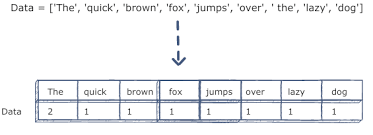

In [38]:
df.head()

,text,label
0,series demonstrating adage good goose also goo...,negative
21,good goose,pozitive
22,good,pozitive
33,gander occasionally amuses none amount much story,negative
46,amuses,pozitive


In [39]:
df.iloc[0]

text     series demonstrating adage good goose also goo...
label                                             negative
Name: 0, dtype: object

In [42]:
from sklearn import model_selection, preprocessing

In [43]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(df["text"],
                                                                   df["label"], 
                                                                    random_state = 1)

In [44]:
train_y[0:5]

118788    pozitive
89514     negative
86857     pozitive
140626    negative
153243    pozitive
Name: label, dtype: object

In [45]:
encoder = preprocessing.LabelEncoder()

In [46]:
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

In [49]:
train_y[0:5] # number 1 represent  positive  comments
             # number 0 represent  negative  comments

array([1, 0, 1, 0, 1])

In [50]:
test_y[0:5]

array([1, 0, 1, 0, 0])

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

In [53]:
vectorizer = CountVectorizer()
vectorizer.fit(train_x)

CountVectorizer()

In [54]:
x_train_count = vectorizer.transform(train_x)
x_test_count = vectorizer.transform(test_x)

In [56]:
vectorizer.get_feature_names()[0:15]

['aaliyah',
 'abagnale',
 'abandon',
 'abandoned',
 'abbass',
 'abbott',
 'abc',
 'abdul',
 'abel',
 'abhorrent',
 'abhors',
 'abiding',
 'ability',
 'abject',
 'able']

In [57]:
x_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

###  3-2) TF-IDF Vectorizer

* _**TF**_ stands for **Term Frequency** 

* _**IDF**_ stands for **Inverse Data Frequency**


* **Term Frequency (TF)**: gives us the frequency of the word in each document in the corpus. It is the ratio of number of times the word appears in a document compared to the total number of words in that document. It increases as the number of occurrences of that word within the document increases.



* **Inverse Data Frequency (IDF):** used to calculate the weight of rare words across all documents in the corpus. The words that occur rarely in the corpus have a high IDF score.




* Let’s take an example to get a clearer understanding.
  * Sentence 1 : The car is driven on the road.
  * Sentence 2: The truck is driven on the highway.


* In this example, each sentence is a separate document.

![alt text](https://cdn-media-1.freecodecamp.org/images/1*q3qYevXqQOjJf6Pwdlx8Mw.png)

* TF-IDF Vectorizer has 3 levels
  * word level
  * ngram level 
  * characters level 

#### 3.2.1-) Word Level TF-IDF Vectorizer

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [65]:
word_level_vectorizer = TfidfVectorizer()
word_level_vectorizer.fit(train_x)

TfidfVectorizer()

In [66]:
x_train_word_level = word_level_vectorizer.transform(train_x)
x_test_word_level = word_level_vectorizer.transform(test_x)

In [67]:
word_level_vectorizer.get_feature_names()[0:15]

['aaliyah',
 'abagnale',
 'abandon',
 'abandoned',
 'abbass',
 'abbott',
 'abc',
 'abdul',
 'abel',
 'abhorrent',
 'abhors',
 'abiding',
 'ability',
 'abject',
 'able']

In [68]:
x_train_word_level.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### 3.2.2-) N_gram Level TF-IDF Vectorizer

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [70]:
ngram_vectorizer = TfidfVectorizer(ngram_range = (2,3))
ngram_vectorizer.fit(train_x)

TfidfVectorizer(ngram_range=(2, 3))

In [71]:
x_train_ngram = ngram_vectorizer.transform(train_x)
x_test_ngram = ngram_vectorizer.transform(test_x)

In [72]:
ngram_vectorizer.get_feature_names()[0:15]

['aaliyah one',
 'aaliyah one starring',
 'abagnale antic',
 'abandon hold',
 'abandon hold promise',
 'abandon hope',
 'abandon hope good',
 'abandon however',
 'abandon however canned',
 'abandon leave',
 'abandon leave wanting',
 'abandon political',
 'abandon political madness',
 'abandon script',
 'abandon script go']

#### 3.2.3-) Characters Level TF-IDF Vectorizer

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [76]:
chars_vectorizer = TfidfVectorizer(analyzer = "char", ngram_range = (2,3))
chars_vectorizer.fit(train_x)

TfidfVectorizer(analyzer='char', ngram_range=(2, 3))

In [78]:
x_train_chars =chars_vectorizer.transform(train_x)
x_test_chars =chars_vectorizer.transform(test_x)

In [79]:
chars_vectorizer.get_feature_names()[0:15]

[' a',
 ' aa',
 ' ab',
 ' ac',
 ' ad',
 ' ae',
 ' af',
 ' ag',
 ' ah',
 ' ai',
 ' ak',
 ' al',
 ' am',
 ' an',
 ' ap']

In [80]:
x_train_chars.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.10803509, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## 4-)Sentiment Classification with Machine Learning models

### 4.1-)Logistic Regression

#### 4.1.1-) Logistic Regression for CountVectorizer 

In [83]:
from sklearn import linear_model, model_selection

In [86]:
loj = linear_model.LogisticRegression()
loj_model = loj.fit(x_train_count, train_y)
accuracy = model_selection.cross_val_score(loj_model, 
                                           x_test_count, 
                                           test_y, 
                                           cv = 10).mean()

print("CountVectorizer  Accuracy Ratio:", accuracy)

CountVectorizer  Accuracy Ratio: 0.8368200836820083


#### 4.1.2-) Logistic Regression for Word Level TF-IDF Vectorizer

In [88]:
loj = linear_model.LogisticRegression()
loj_model1 = loj.fit(x_train_word_level,train_y)
accuracy1 = model_selection.cross_val_score(loj_model1, 
                                           x_test_word_level,
                                           test_y, 
                                           cv = 10).mean()

print("Word-Level TF-IDF Vectorizer  Accuracy Ratio:", accuracy1)

Word-Level TF-IDF Vectorizer  Accuracy Ratio: 0.8331066945606695


#### 4.1.3-) Logistic Regression for N_gram Level TF-IDF Vectorizer

In [89]:
loj = linear_model.LogisticRegression()
loj_model2 = loj.fit(x_train_ngram,train_y)
accuracy2 = model_selection.cross_val_score(loj_model2, 
                                           x_test_ngram, 
                                           test_y, 
                                           cv = 10).mean()

print("N-GRAM TF-IDF Vectorizer  Accuracy Ratio:", accuracy2)

N-GRAM TF-IDF Vectorizer  Accuracy Ratio: 0.7481694560669456


#### 4.1.2-) Logistic Regression for Characters Level TF-IDF Vectorizer

In [90]:
loj = linear_model.LogisticRegression()
loj_model3 = loj.fit(x_train_chars,train_y)
accuracy3 = model_selection.cross_val_score(loj_model3, 
                                           x_test_chars, 
                                           test_y, 
                                           cv = 10).mean()

print("Characters Level TF-IDF Vectorizer Accuracy Ratio:", accuracy3)

Characters Level TF-IDF Vectorizer Accuracy Ratio: 0.7797071129707113


### 4.2-)Naive Bayes

In [92]:
from sklearn import model_selection , naive_bayes

#### 4.2.1-) Naive Bayes for CountVectorizer 

In [94]:
nb = naive_bayes.MultinomialNB()
nb_model = nb.fit(x_train_count,train_y)
accuracy4 = model_selection.cross_val_score(nb_model, 
                                           x_test_count, 
                                           test_y, 
                                           cv = 10).mean()

print("CountVectorizer  Accuracy Ratio:", accuracy4)

CountVectorizer  Accuracy Ratio: 0.8327928870292887


#### 4.2.2-) Naive Bayes for Word Level TF-IDF Vectorizer 

In [95]:
nb = naive_bayes.MultinomialNB()
nb_model1 = nb.fit(x_train_word_level,train_y)
accuracy5 = model_selection.cross_val_score(nb_model1, 
                                           x_test_word_level, 
                                           test_y, 
                                           cv = 10).mean()

print("Word-Level TF-IDF Vectorizer  Accuracy Ratio:", accuracy)

Word-Level TF-IDF Vectorizer  Accuracy Ratio: 0.8368200836820083


#### 4.2.3-) Naive Bayes for  N_gram Level TF-IDF Vectorizer

In [97]:
nb = naive_bayes.MultinomialNB()
nb_model2= nb.fit(x_train_ngram,train_y)
accuracy6 = model_selection.cross_val_score(nb_model2, 
                                           x_test_ngram, 
                                           test_y, 
                                           cv = 10).mean()

print("N-GRAM TF-IDF Vectorizer  Accuracy Ratio::", accuracy6)

N-GRAM TF-IDF Vectorizer  Accuracy Ratio:: 0.7686192468619246


#### 4.2.4-) Naive Bayes for  Characters Level TF-IDF Vectorizer

In [98]:
nb = naive_bayes.MultinomialNB()
nb_model3 = nb.fit(x_train_chars,train_y)
accuracy7 = model_selection.cross_val_score(nb_model3, 
                                           x_test_chars, 
                                           test_y, 
                                           cv = 10).mean()

print("Characters Level TF-IDF Vectorizer Accuracy Ratio:", accuracy7)

Characters Level TF-IDF Vectorizer Accuracy Ratio: 0.756276150627615


## 5-) Prediction of the Comments (postive or negative) 

 * We use **Logistic Regression for CountVectorizer Model** to predict the comments for films  which will be done by audience. Because it has the highset accuracy score  
 
 * By using this model , we will predict whether new comment is positive or negative.

In [99]:
loj_model

LogisticRegression()

In [100]:
new_comments=pd.Series("this film is very nice and good i like it")

In [101]:
v = CountVectorizer()

In [102]:
v.fit(train_x)

CountVectorizer()

In [103]:
new_comments=v.transform(new_comments)

In [104]:
loj_model.predict(new_comments)
# number 1 represent positive comments

array([1])

In [105]:
new_comments1=pd.Series("no not good look at that shit very bad")

In [106]:
v1 = CountVectorizer()
v1.fit(train_x)
new_comments1 = v.transform(new_comments1)

In [108]:
loj_model.predict(new_comments1)
# number 0 represent negative  comments

array([0])